## <font color = red> Sự kết hợp của các yếu tố nào làm gia tăng nguy cơ đột quỵ cao nhất? </font>

### **Bước 1: Chọn các đặc trưng có khả năng ảnh hưởng**
- **Mục tiêu**: Xác định các yếu tố có tiềm năng liên quan đến nguy cơ đột quỵ.  
- **Thực hiện**: 
  - Tính ma trận tương quan giữa các đặc trưng và biến mục tiêu `stroke`.
  - Dựa vào kiến thức y học, lưu ý các đặc trưng như: 
    - `hypertension` (huyết áp cao)
    - `heart_disease` (bệnh tim)
    - `avg_glucose_level` (mức glucose trung bình)
    - `bmi` (chỉ số BMI)
    - `smoking_status` (tình trạng hút thuốc)
    - `age` (tuổi)
  - Loại bỏ các đặc trưng ít liên quan hoặc có tương quan rất thấp với `stroke`.

---

In [97]:
import warnings 
warnings.filterwarnings('ignore')
# basic libraries
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time
#visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from pywaffle import Waffle
%matplotlib inline
init_notebook_mode(connected= True)
#Common model helpers
from sklearn.preprocessing import (StandardScaler,  LabelEncoder, OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,auc, precision_score, recall_score, f1_score,  roc_auc_score, confusion_matrix)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)
# dimensionality reduction
from sklearn.decomposition import PCA
# from umap import UMAP
import pylab as pl
# imbalance dataset handling
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)


from imblearn.over_sampling import (SMOTE,
                                    ADASYN)

# model algorithams
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [98]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df['phanloai_bmi'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['phanloai_age'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['phanloai_glucose'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])
df.dtypes

id                      int64
gender                 object
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
Residence_type         object
avg_glucose_level     float64
bmi                   float64
smoking_status         object
stroke                  int64
phanloai_bmi         category
phanloai_age         category
phanloai_glucose     category
dtype: object

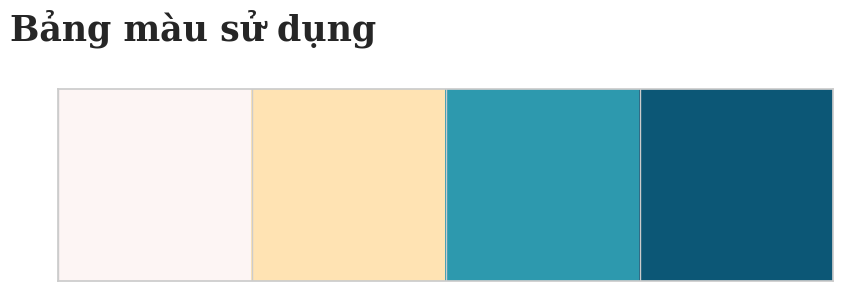

In [99]:
colors = ['#fdf5f4','#ffe3B3','#2d99ae','#0c5776']
palette = sns.color_palette( palette = colors)
sns.palplot(palette, size =2.5)
plt.text(-0.75,-0.75,'Bảng màu sử dụng', {'font':'serif', 'size':25, 'weight':'bold'})
plt.show()

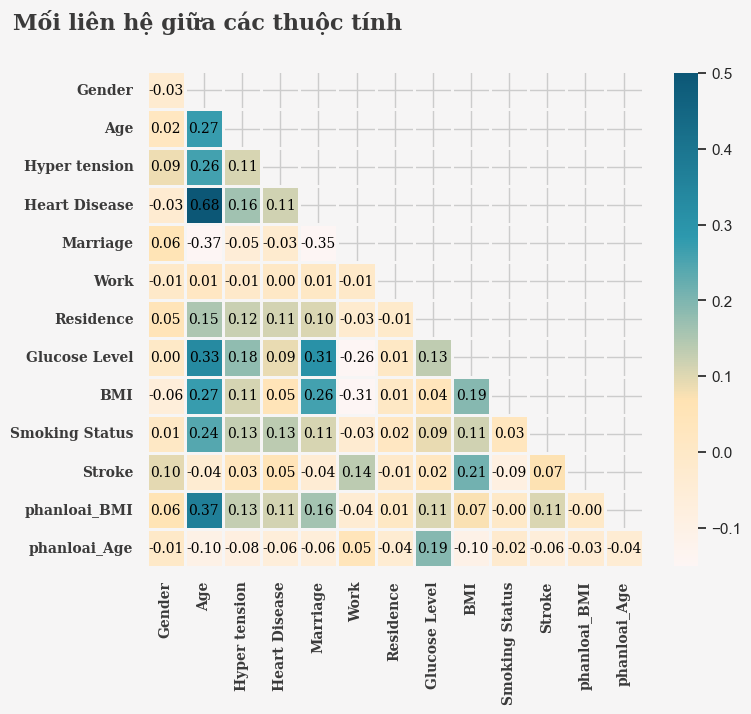

In [114]:
df_copy = df.copy()
df_copy['age'] = df_copy['age'].apply(lambda x: np.log(x + 10) * 3)
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].apply(lambda x: np.log(x + 10) * 2)
df_copy['bmi'] = df_copy['bmi'].apply(lambda x: np.log(x + 10) * 2)
ohe = OneHotEncoder()
ss = StandardScaler()
le = LabelEncoder()
for col in df_copy.columns:
    df_copy[col] = le.fit_transform(df_copy[col])

cols = df_copy.columns
df_copy[cols] = ss.fit_transform(df_copy[cols])
df_corr = df_copy.drop(columns=['id']).corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

mask = mask[1:, :-1]
corr = df_corr.iloc[1:, :-1].copy()
colors = ['#fdf5f4', '#ffe3B3', '#2d99ae', '#0c5776']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=colormap,
            vmin=-0.15, vmax=0.5, cbar_kws={"shrink": .8, "orientation": "vertical"}, ax=ax,
            linewidths=1, linecolor='#f6f5f5', square=True,
            annot_kws={'font': 'serif', 'size': 10, 'color': 'black'})
ax.tick_params(axis='y', rotation=0)
xticks = ['Gender', 'Age', 'Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 
          'BMI', 'Smoking Status', 'Stroke', 'phanloai_BMI', 'phanloai_Age']
yticks = ['Gender', 'Age', 'Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 
          'BMI', 'Smoking Status', 'Stroke', 'phanloai_BMI', 'phanloai_Age']

ax.set_xticklabels(xticks, fontdict={'fontname': 'serif', 'size': 10, 'weight': 'bold'}, rotation=90, alpha=0.9)
ax.set_yticklabels(yticks, fontdict={'fontname': 'serif', 'size': 10, 'weight': 'bold'}, rotation=0, alpha=0.9)
ax.text(-3.5, -1.1, 'Mối liên hệ giữa các thuộc tính', {'font': 'serif', 'size': 16, 'weight': 'bold'}, alpha=0.9)
plt.show()

## **Nhận xét**: 
- Stroke chỉ bị ảnh hưởng bởi các yếu tố: BMI, work, gender, heart disease, hypertension. 

### **Bước 3: Tạo các nhóm hoặc tổ hợp đặc trưng**
- **Mục tiêu**: Tìm hiểu sự kết hợp giữa các yếu tố gây nên nguy cơ đột quỵ.  
- **Thực hiện**:
  - Tạo các tổ hợp đặc trưng, ví dụ: 
    - `age` và `hypertension`
    - `heart_disease` và `smoking_status`
    - `avg_glucose_level` và `bmi`
    - ......
  - Vẽ biểu đồ cho từng nhóm và đưa ra nhận xét. 

---

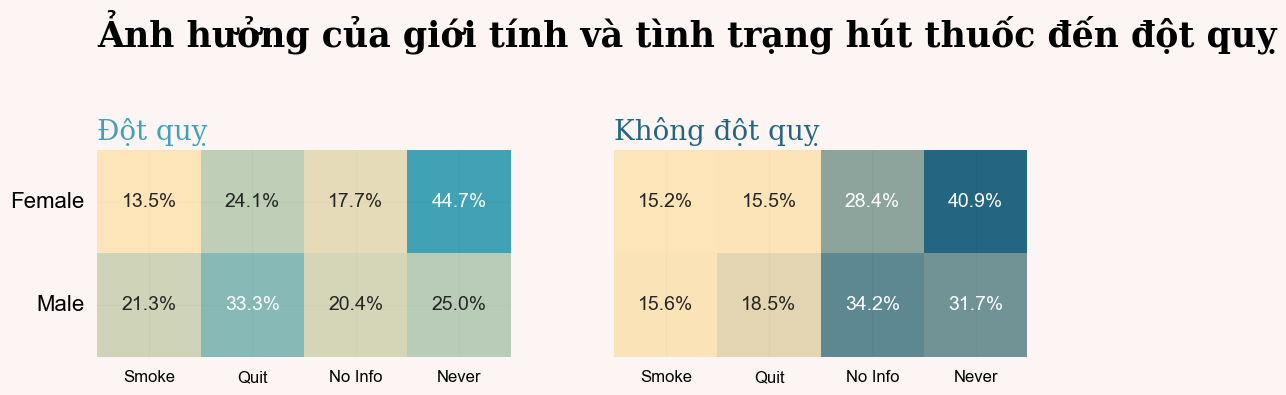

In [111]:
fig = plt.figure(figsize=(12, 6), dpi=100)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('#fdf5f4')
ax0.set_facecolor('#fdf5f4')
ax1.set_facecolor('#fdf5f4')
healthy = df[df['stroke'] == 0]
stroke = df[df['stroke'] == 1]

gender_order = ['Female', 'Male']
smoking_order = ['smokes', 'formerly smoked', 'Unknown', 'never smoked']
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ffe3B3', '#2d99ae'], N=256)
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ffe3B3', '#0c5776'], N=256)
data_stroke = pd.crosstab(stroke['gender'], stroke['smoking_status'], normalize='index').loc[gender_order, smoking_order]
data_no_stroke = pd.crosstab(healthy['gender'], healthy['smoking_status'], normalize='index').loc[gender_order, smoking_order]
sns.heatmap(ax=ax0, data=data_stroke, linewidths=0, square=True, cbar=False, cmap=colormap1, 
            annot=True, fmt='.1%', annot_kws={"fontsize": 14}, alpha=0.9)
sns.heatmap(ax=ax1, data=data_no_stroke, linewidths=0, square=True, cbar=False, cmap=colormap2, 
            annot=True, fmt='.1%', annot_kws={"fontsize": 14}, alpha=0.9)

ax0.text(0, -1., 'Ảnh hưởng của giới tính và tình trạng hút thuốc đến đột quỵ', 
         fontdict={'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 25})
ax0.text(0, -0.1, 'Đột quỵ', fontdict={'family': 'serif', 'color': "#2d99ae", 'size': 20}, alpha=0.9)
ax1.text(0, -0.1, 'Không đột quỵ', fontdict={'family': 'serif', 'color': "#0c5776", 'size': 20}, alpha=0.9)
ax0.set_xticklabels(['Smoke', 'Quit', 'No Info', 'Never'], fontsize=12, color='black')
ax1.set_xticklabels(['Smoke', 'Quit', 'No Info', 'Never'], fontsize=12, color='black')
ax0.set_yticklabels(gender_order, fontsize=16, color='black', rotation=0)
ax1.axes.get_yaxis().set_visible(False)
ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
plt.tight_layout()
plt.show()


**Nhận xét**: 
- Theo dữ liệu trên, nam giới bỏ hút thuốc và nữ giới chưa từng hút thuốc lại có tỉ lệ đột quỵ cao ! 

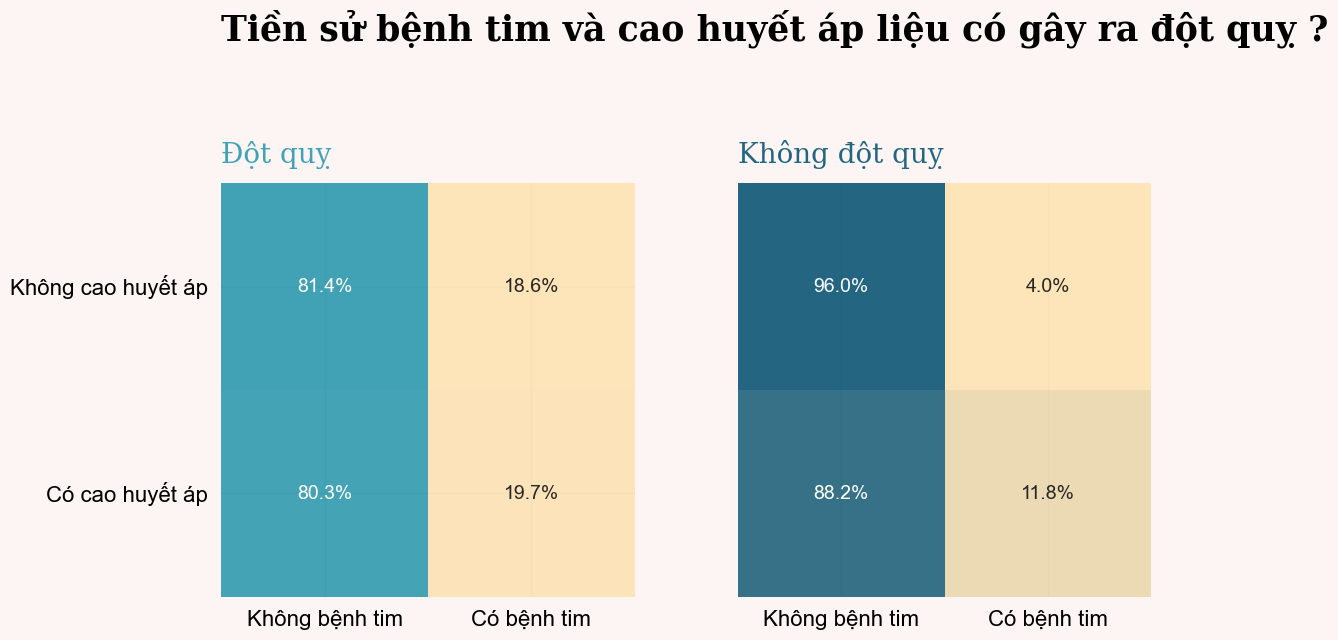

In [115]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('#fdf5f4')
ax0.set_facecolor('#fdf5f4')
ax1.set_facecolor('#fdf5f4')
healthy = df[df['stroke'] == 0]
stroke = df[df['stroke'] == 1]
col1 = ["#ffe3B3", "#2d99ae"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N=256)
col2 = ["#ffe3B3", "#0c5776"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)
data_stroke = pd.crosstab(stroke['hypertension'], stroke['heart_disease'], normalize='index')
data_no_stroke = pd.crosstab(healthy['hypertension'], healthy['heart_disease'], normalize='index')
sns.heatmap(ax=ax0, data=data_stroke, linewidths=0, square=True, cbar=False, cmap=colormap1, 
            annot=True, fmt='.1%', annot_kws={"fontsize": 14}, alpha=0.9)
sns.heatmap(ax=ax1, data=data_no_stroke, linewidths=0, square=True, cbar=False, cmap=colormap2, 
            annot=True, fmt='.1%', annot_kws={"fontsize": 14}, alpha=0.9)
ax0.text(0, -0.69, 'Tiền sử bệnh tim và cao huyết áp liệu có gây ra đột quỵ ?', 
         fontdict={'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 25})
ax0.text(0, -0.1, 'Đột quỵ', fontdict={'family': 'serif', 'color': "#2d99ae", 'size': 20}, alpha=0.9)
ax1.text(0, -0.1, 'Không đột quỵ', fontdict={'family': 'serif', 'color': "#0c5776", 'size': 20}, alpha=0.9)
ax0.set_xticklabels(['Không bệnh tim', 'Có bệnh tim'], fontsize=16, color='black')
ax1.set_xticklabels(['Không bệnh tim', 'Có bệnh tim'], fontsize=16, color='black')
ax0.set_yticklabels(['Không cao huyết áp', 'Có cao huyết áp'], fontsize=16, color='black', rotation=0)
ax1.axes.get_yaxis().set_visible(False)
ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
plt.tight_layout()
plt.show()

**Nhận xét:** 
- Người không bị bệnh tim và không cao huyết áp vẫn có nguy cơ cao bị đột quỵ !

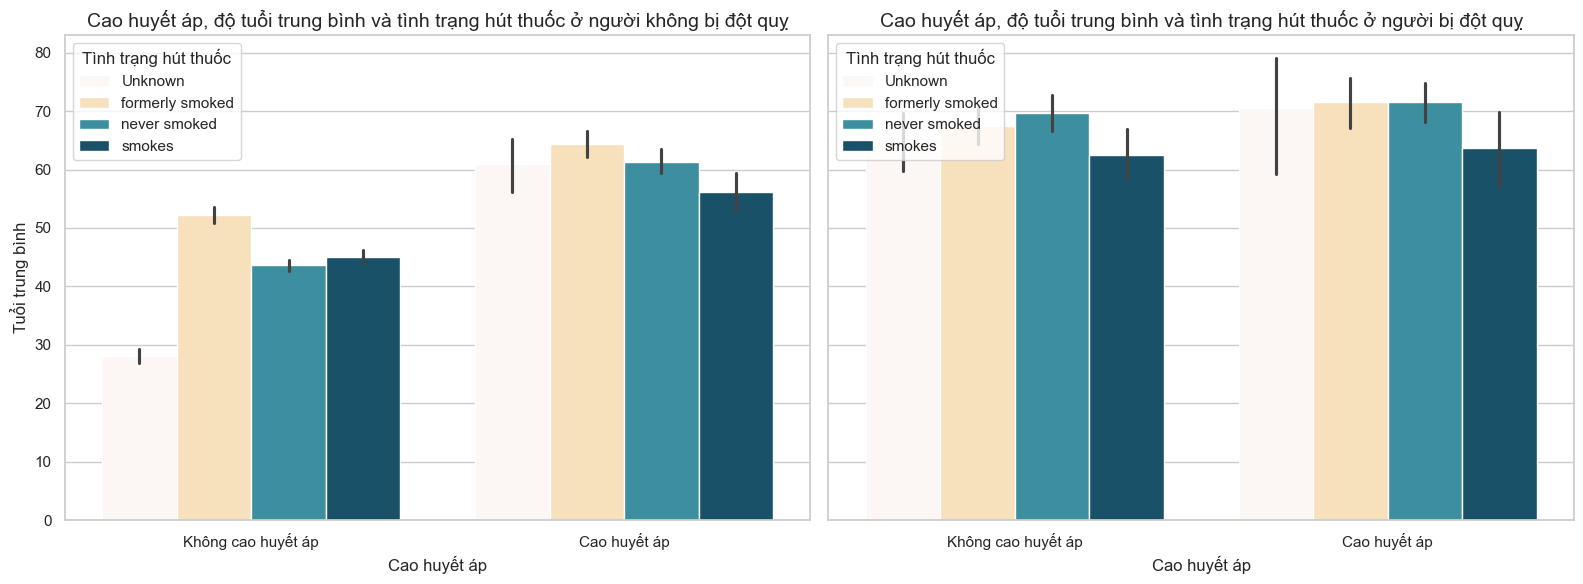

In [125]:
data_stroke_0 = df[df['stroke'] == 0]
data_stroke_1 = df[df['stroke'] == 1]
sns.set(style="whitegrid")
colors = ['#fdf5f4','#ffe3B3','#2d99ae','#0c5776']
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
hue_order = sorted(df['smoking_status'].unique())
# Biểu đồ cho stroke = 0
sns.barplot(
    data=data_stroke_0, 
    x='hypertension', 
    y='age', 
    hue='smoking_status',
    hue_order=hue_order, 
    palette=colors, 
    ax=axes[0]
)
axes[0].set_title('Cao huyết áp, độ tuổi trung bình và tình trạng hút thuốc ở người không bị đột quỵ', fontsize=14)
axes[0].set_xlabel('Cao huyết áp', fontsize=12)
axes[0].set_ylabel('Tuổi trung bình', fontsize=12)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Không cao huyết áp', 'Cao huyết áp'])
axes[0].legend(title='Tình trạng hút thuốc', loc='upper left')
# Biểu đồ cho stroke = 1
sns.barplot(
    data=data_stroke_1, 
    x='hypertension', 
    y='age', 
    hue='smoking_status', 
    hue_order=hue_order,
    palette=colors, 
    ax=axes[1]
)
axes[1].set_title('Cao huyết áp, độ tuổi trung bình và tình trạng hút thuốc ở người bị đột quỵ', fontsize=14)
axes[1].set_xlabel('Cao huyết áp', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Không cao huyết áp', 'Cao huyết áp'])
axes[1].legend(title='Tình trạng hút thuốc', loc='upper left')
plt.tight_layout()
# Hiển thị biểu đồ
plt.show()

**Nhận xét:**
- Đa số người bị đột quỵ có độ tuổi trung bình cao ( 60 - 70 tuổi). 
- Người chưa từng hút thuốc và đang hút thuốc lại có khả năng đột quỵ cao nhất ! 
- Trong khi người hiện đang hút thuốc lại có tỉ lệ đột quỵ thấp nhất ! 

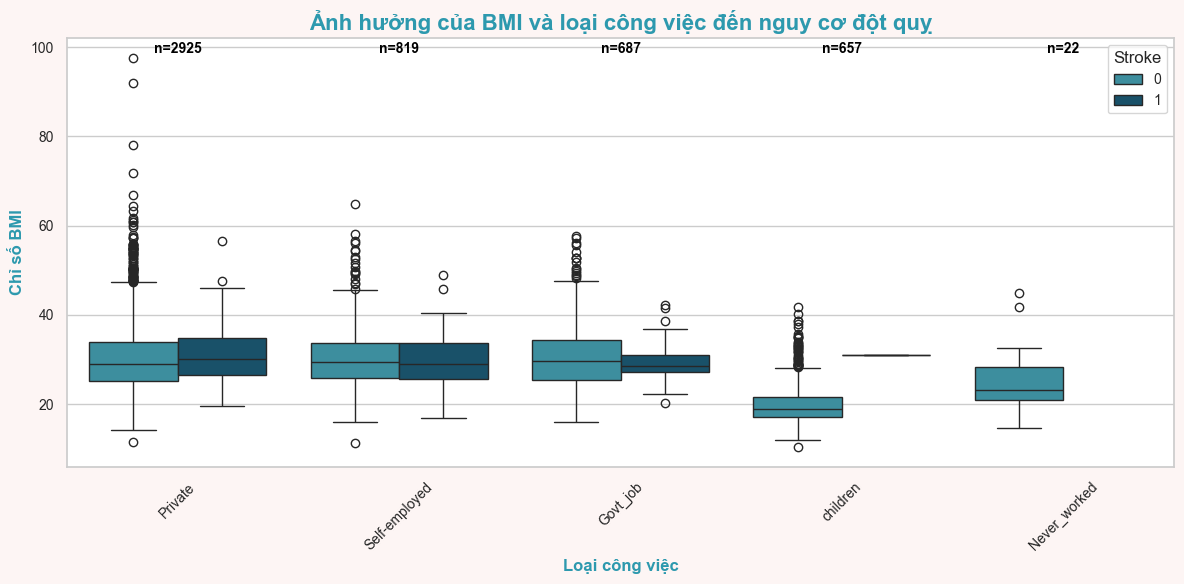

In [126]:
# Tạo figure và thiết lập màu nền
plt.figure(figsize=(12, 6))
plt.gcf().set_facecolor('#fdf5f4')

# Vẽ boxplot
sns.boxplot(data=df, x='work_type', y='bmi', hue='stroke', palette=['#2d99ae', '#0c5776'])

# Thêm tiêu đề và chú thích trục
plt.title('Ảnh hưởng của BMI và loại công việc đến nguy cơ đột quỵ', fontsize=16, fontweight='bold', color='#2d99ae')
plt.xlabel('Loại công việc', fontsize=12, fontweight='bold', color='#2d99ae')
plt.ylabel('Chỉ số BMI', fontsize=12, fontweight='bold', color='#2d99ae')

# Tùy chỉnh nhãn trên trục x
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Tính số lượng mẫu của từng nhóm
work_type_counts = df['work_type'].value_counts()

# Hiển thị giá trị của work_type lên biểu đồ
# Lấy thứ tự các nhóm trên boxplot từ trục x
x_order = df['work_type'].value_counts().index
for i, work_type in enumerate(x_order):
    count = work_type_counts[work_type]
    plt.text(i, df['bmi'].max() + 1, f'n={count}', 
             horizontalalignment='center', fontsize=10, color='black', fontweight='bold')

# Hiển thị chú thích (legend)
plt.legend(title='Stroke', title_fontsize=12, fontsize=10, loc='upper right')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


**Nhận xét**: 
- Đa phần người đột quỵ có BMI trong khoảng 25 - 35. 
- Người đột quỵ không có ai có BMI trên 60. 
- Số lượng người đột quỵ nhiều nhất là ở người làm công việc Private. 

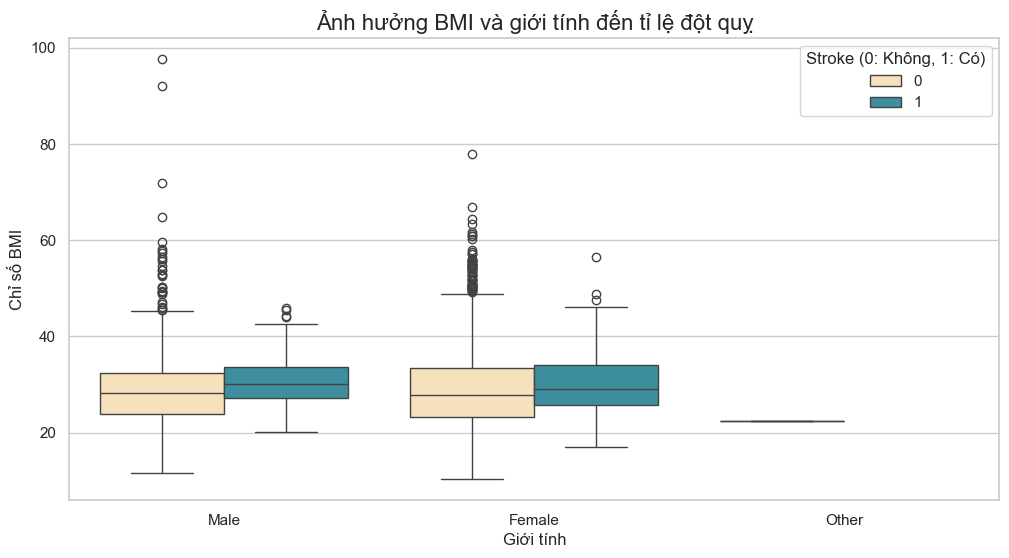

In [128]:
# Màu sắc tùy chỉnh
colors = ['#ffe3B3', '#2d99ae']  # Chỉ lấy 2 màu đầu cho stroke

# Tạo biểu đồ hộp (boxplot) cho BMI theo gender và stroke với màu tùy chỉnh
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='gender', y='bmi', hue='stroke', palette=colors)

# Chỉnh sửa tiêu đề và nhãn
plt.title('Ảnh hưởng BMI và giới tính đến tỉ lệ đột quỵ', fontsize=16)
plt.xlabel('Giới tính', fontsize=12)
plt.ylabel('Chỉ số BMI', fontsize=12)

# Thêm nhãn cho Stroke
plt.legend(title='Stroke (0: Không, 1: Có)', loc='upper right')

# Hiển thị biểu đồ
plt.show()

**Nhận xét**: 
- Ở cả nam và nữ, người đột quỵ thường có BMI cao hơn người không bị.
- BMI của người đột quỵ chỉ nằm trong mức 20 đến 60. 
- Một số người có BMI rất cao hoặc rất thấp lại không bị đột quỵ. 
- Người thuộc giới tính thứ ba có số lượng đột quỵ rất ít, điều này là do có rất ít số liệu. 
- Người đột quỵ ở cả nam và nữ giới đều có số lượng trong khoảng 25 - 35. 

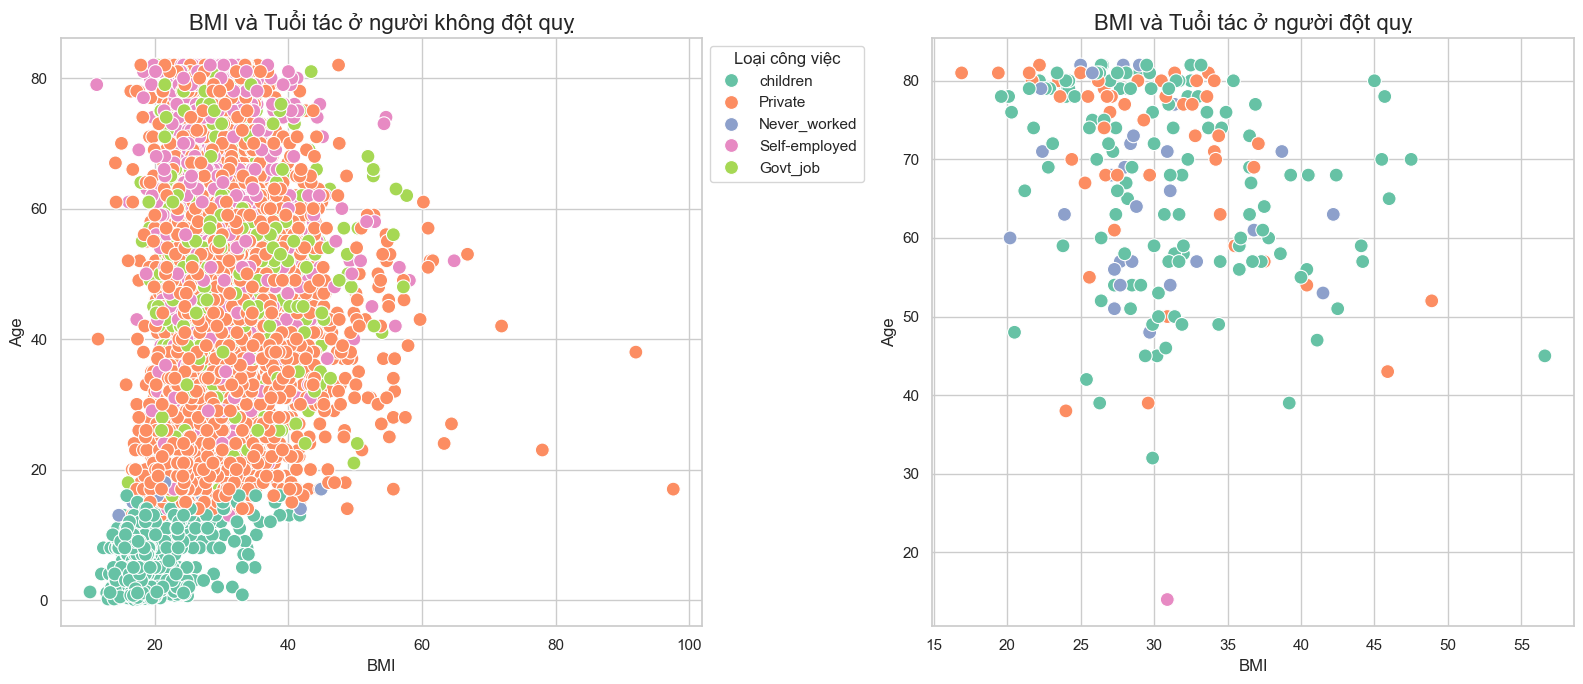

In [130]:
# Tạo hai DataFrame riêng biệt, một cho stroke = 0 và một cho stroke = 1
df_stroke_0 = df[df['stroke'] == 0]
df_stroke_1 = df[df['stroke'] == 1]

# Tạo hai biểu đồ phân tán cho mỗi nhóm stroke
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Biểu đồ cho stroke = 0
sns.scatterplot(data=df_stroke_0, x='bmi', y='age', hue='work_type', palette='Set2', ax=axes[0], marker="o", s=100)
axes[0].set_title('BMI và Tuổi tác ở người không đột quỵ', fontsize=16)
axes[0].set_xlabel('BMI', fontsize=12)
axes[0].set_ylabel('Age', fontsize=12)
axes[0].legend(title='Loại công việc', loc='upper left', bbox_to_anchor=(1, 1))

# Biểu đồ cho stroke = 1
sns.scatterplot(data=df_stroke_1, x='bmi', y='age', hue='work_type', palette='Set2', ax=axes[1], marker="o", s=100, legend = False)
axes[1].set_title('BMI và Tuổi tác ở người đột quỵ', fontsize=16)
axes[1].set_xlabel('BMI', fontsize=12)
axes[1].set_ylabel('Age', fontsize=12)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


**Nhận xét:** 
- Người đột quỵ đa phần nằm ở nhóm làm công việc Private và never work và có BMI tập trung trong khoảng 25 - 35. 
- 


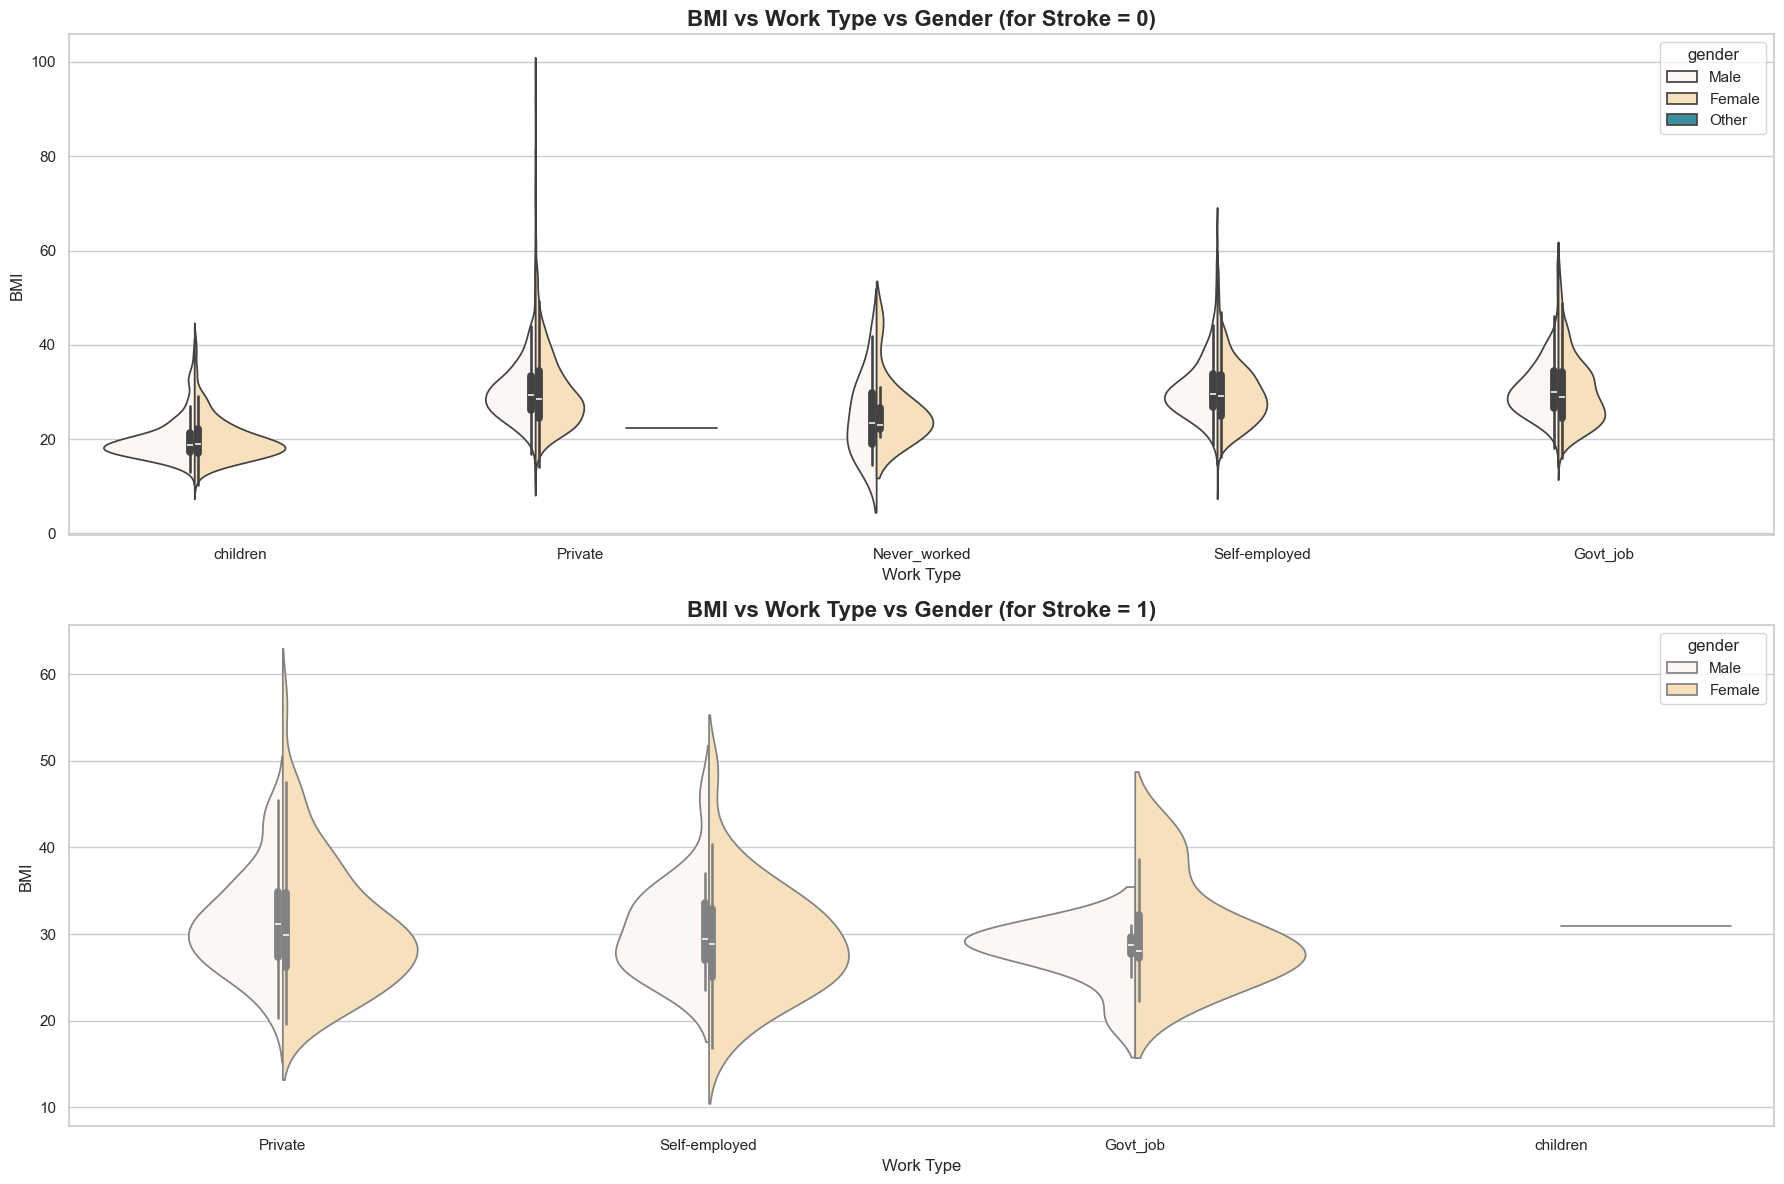

In [107]:
# Tạo figure với 2 subplot (2 hàng, 1 cột)
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

# Biểu đồ cho stroke = 0
df_no_stroke = df[df['stroke'] == 0]
sns.violinplot(data=df_no_stroke, x='work_type', y='bmi', hue='gender', split=True, palette=["#fdf5f4", "#ffe3B3", "#2d99ae"], ax=ax[0])
ax[0].set_title('BMI vs Work Type vs Gender (for Stroke = 0)', fontsize=16, weight='bold')
ax[0].set_xlabel('Work Type', fontsize=12)
ax[0].set_ylabel('BMI', fontsize=12)

# Biểu đồ cho stroke = 1
df_stroke = df[df['stroke'] == 1]
sns.violinplot(data=df_stroke, x='work_type', y='bmi', hue='gender', split=True, palette=["#fdf5f4", "#ffe3B3", "#2d99ae"], ax=ax[1])
ax[1].set_title('BMI vs Work Type vs Gender (for Stroke = 1)', fontsize=16, weight='bold')
ax[1].set_xlabel('Work Type', fontsize=12)
ax[1].set_ylabel('BMI', fontsize=12)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
